In [1]:
# Libraries

import numpy
import os
import shutil

In [2]:
# Code

from src.cnn.dataset import GeneDataset
from src.cnn.models  import Zrimec2020c

from src.cnn import core    as cnn_core
from src.cnn import dataset as cnn_dataset
from src.cnn import model   as cnn_model
from src.cnn import plot    as cnn_plot
from src.cnn import util    as cnn_util
from src.io  import loader  as data_loader

# 1. Setup

In [3]:
# Setup some directory paths.

OUT_SUBFOLDER = 'nbp06-zrimec2020c'
RES_SUBFOLDER = ''

CWD = os.getcwd()
OUT = os.path.join(CWD, 'out')
RES = os.path.join(CWD, 'res')

OUT_PLOT  = os.path.join(OUT, 'plot',  OUT_SUBFOLDER)
OUT_MODEL = os.path.join(OUT, 'model', OUT_SUBFOLDER)
RES_PLANT = os.path.join(RES, 'plant', RES_SUBFOLDER)
RES_MODEL = os.path.join(RES, 'model', RES_SUBFOLDER)
RES_NBP04 = os.path.join(OUT, 'data', 'nbp04-feature')
RES_NBP05 = os.path.join(OUT, 'data', 'nbp05-target')

shutil.rmtree(OUT_PLOT,  ignore_errors = True)
shutil.rmtree(OUT_MODEL, ignore_errors = True)

os.makedirs(OUT_PLOT,  exist_ok = True)
os.makedirs(OUT_MODEL, exist_ok = True)

print(f'     Root Directory : {CWD}')
print(f'   Output Directory : {OUT}')
print(f' Resource Directory : {RES}')

     Root Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\out
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\res


In [4]:
# Device

DEVICE = cnn_core.get_device(only_cpu = False)

Graphic devices : 1
Selected device : cuda


In [5]:
# Load the input <gene> features

gene_sequences = data_loader.load_fasta(
	filename  = os.path.join(RES_NBP04, 'features-bp2150.fasta'),
	to_string = True
)

gene_frequency = data_loader.load_npz(
	filename = os.path.join(RES_NBP04, 'features-frequency.npz')
)

gene_stability = data_loader.load_npz(
	filename = os.path.join(RES_NBP04, 'features-stability.npz')
)

tpm_label = data_loader.load_labels(
	filename = os.path.join(RES_NBP05, 'target-labels.json'),
	to_numpy = True
)

tpm_order = data_loader.load_labels(
	filename = os.path.join(RES_NBP05, 'target-order.json')
)

# 2. Classification

In [6]:
# Define basic data parameters

config = {
	'random_seed' : None,
	'batch_size' : {
		'train' : 64,
		'valid' : 64,
		'test'  : 64
	},
	'split_size' : {
		'valid' : 0.2,
		'test'  : 0.2
	},
	'input' : {
		'channels' : 1,
		'height'   : 4,
		'width'    : 2150,
		'features' : 64
	},
	'output' : {
		'group0'  : 'tissue',
		'group1'  : 'tissue-mean',
		'length'  : 8,
		'classes' : 5
	}
}

# Ensure correct
config['output']['length']  = len(tpm_order[config['output']['group0']])

In [7]:
# Lock random

config['random_seed'] = cnn_core.lock_random(
	seed = config['random_seed'],
	generate_seed = True
)

print('Random seed : {}'.format(config['random_seed']))

Random seed : 930129137


## 2.1 Data

In [8]:
# Get the correct output group

gene_targets = {
	key : numpy.array(value[config['output']['group1']], dtype = numpy.int64)
	for key, value in tpm_label.items()
}

In [9]:
# Update number of classes

classes = set(numpy.array([x for x in gene_targets.values()]).flatten())

print(f'Classes Length : {len(classes)}')
print(f'Classes Unique : ' + ', '.join(str(x) for x in classes))

config['output']['classes'] = len(classes)

Classes Length : 5
Classes Unique : 0, 1, 2, 3, 4


In [10]:
# Transform the data dictionaries into lists

names = sorted(list(gene_sequences.keys()))

sequences = numpy.array([gene_sequences[key] for key in names])
features  = numpy.array([gene_frequency[key] for key in names])
targets   = numpy.array([gene_targets[key]   for key in names])

In [11]:
# Create the dataset and generte split indices using sklearn

dataset = GeneDataset(
	names       = names,
	sequences   = sequences,
	features    = features,
	targets     = targets,
	expand_dims = None
)

train_idx, valid_idx, test_idx = cnn_dataset.generate_split_indices(
	targets     = targets,
	valid_split = config['split_size']['valid'],
	test_split  = config['split_size']['test'],
	random_seed = config['random_seed']
)

Train percentage : 64.00
Valid percentage : 16.00
 Test percentage : 20.00


In [12]:
# Create train dataloader and display batch dimensions

train_dataloader = cnn_dataset.to_dataloader(
	dataset    = dataset,
	indices    = train_idx,
	batch_size = config['batch_size']['train']
)

cnn_dataset.show_dataloader(
	dataloader = train_dataloader,
	batch_size = config['batch_size']['train']
)

Dataloader  batch  size :     64
Dataloader  batch count :    316
Dataloader sample count : 20,224

     Key shape : (64,)
Sequence shape : torch.Size([64, 4, 2150])
 Feature shape : torch.Size([64, 64])
  Target shape : torch.Size([64, 8])


In [13]:
# Create valid dataloader and display batch dimensions

valid_dataloader = cnn_dataset.to_dataloader(
	dataset    = dataset,
	indices    = valid_idx,
	batch_size = config['batch_size']['valid']
)

cnn_dataset.show_dataloader(
	dataloader = valid_dataloader,
	batch_size = config['batch_size']['valid']
)

Dataloader  batch  size :     64
Dataloader  batch count :     79
Dataloader sample count :  5,056

     Key shape : (64,)
Sequence shape : torch.Size([64, 4, 2150])
 Feature shape : torch.Size([64, 64])
  Target shape : torch.Size([64, 8])


In [14]:
# Create test dataloader and display batch dimensions

test_dataloader = cnn_dataset.to_dataloader(
	dataset    = dataset,
	indices    = test_idx,
	batch_size = config['batch_size']['test']
)

cnn_dataset.show_dataloader(
	dataloader = test_dataloader,
	batch_size = config['batch_size']['test']
)

Dataloader  batch  size :     64
Dataloader  batch count :     99
Dataloader sample count :  6,336

     Key shape : (64,)
Sequence shape : torch.Size([64, 4, 2150])
 Feature shape : torch.Size([64, 64])
  Target shape : torch.Size([64, 8])


## 2.2 Model

In [15]:
# Create and display the model structure

model = Zrimec2020c(params = {
	'other' : {
		'in_height'   : config['input']['height'],
		'in_width'    : config['input']['width'],
		'in_features' : config['input']['features'],
		'dropout'     : 0.25
	},
	'conv1' : {
		'filters' : 64,
		'kernel'  : 9,
		'padding' : 0
	},
	'conv2' : {
		'filters' : 64,
		'kernel'  : 9,
		'padding' : 4
	},
	'conv3' : {
		'filters' : 128,
		'kernel'  : 9,
		'padding' : 4
	},
	'maxpool1' : {
		'kernel'  : 3,
		'padding' : 1
	},
	'maxpool2' : {
		'kernel'  : 3,
		'padding' : 1
	},
	'maxpool3' : {
		'kernel'  : 3,
		'padding' : 1
	},
	'fc1' : {
		'features' : 128
	},
	'fc2' : {
		'features' : 64
	},
	'fc3' : {
		'features' : config['output']['classes'],
		'heads'    : config['output']['length']
	}
})

model.summary(
	batch_size  = config['batch_size']['train'],
	in_height   = config['input']['height'],
	in_width    = config['input']['width'],
	in_features = config['input']['features'],
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Zrimec2020c                              [64, 4, 2150]             [64, 5, 8]                --
├─Zrimec2020: 1-1                        [64, 4, 2150]             [64, 64]                  --
│    └─Conv1d: 2-1                       [64, 4, 2150]             [64, 64, 2142]            2,368
│    └─ReLU: 2-2                         [64, 64, 2142]            [64, 64, 2142]            --
│    └─BatchNorm1d: 2-3                  [64, 64, 2142]            [64, 64, 2142]            128
│    └─Dropout: 2-4                      [64, 64, 2142]            [64, 64, 2142]            --
│    └─MaxPool1d: 2-5                    [64, 64, 2142]            [64, 64, 429]             --
│    └─Conv1d: 2-6                       [64, 64, 429]             [64, 64, 429]             36,928
│    └─ReLU: 2-7                         [64, 64, 429]             [64, 64, 429]             --
│    └─BatchNorm1d: 2-8    

In [16]:
# Convert the model to double and initialize weights and biases

model = model.double()
model = model.apply(cnn_model.he_uniform_weight)
model = model.apply(cnn_model.zero_bias)

In [17]:
# Set the training parameters

criterion = cnn_model.get_criterion(
	query     = 'entropy',
	reduction = 'mean'
)

optimizer = cnn_model.get_optimizer(
	query        = 'adam',
	model        = model,
	lr           = 1e-4,
	betas        = (0.900, 0.999),
	weight_decay = 0.01
)

scheduler = cnn_model.get_scheduler(
	query     = 'plateau',
	mode      = 'min',
	optimizer = optimizer,
	patience  = 3,
	factor    = 0.5,
	min_lr    = 1e-6
)

params = {
	'model'     : model,
	'savebest'  : os.path.join(OUT_MODEL, f'{model.__name__}-best.pth'),
	'savelast'  : os.path.join(OUT_MODEL, f'{model.__name__}-last.pth'),
	'epochs'    : 15,
	'criterion' : criterion,
	'optimizer' : optimizer,
	'scheduler' : scheduler,
	'device'    : DEVICE,
	'verbose'   : True,
	'train_dataloader' : train_dataloader,
	'valid_dataloader' : valid_dataloader,
	'test_dataloader'  : test_dataloader,
	'metrics' : {
		'entropy'  : cnn_model.get_criterion(reduction = 'none', query = 'entropy'),
		'accuracy' : cnn_model.get_criterion(reduction = 'none', query = 'accuracy')
	}
}

## 2.3 Training

In [18]:
# Train and validate the model

report = cnn_model.train_classifier(
	model  = model,
	params = params
)

  0%|          | 0/316 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/316 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/316 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/316 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/316 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/316 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/316 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/316 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/316 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/316 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/316 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/316 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/316 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/316 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/316 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

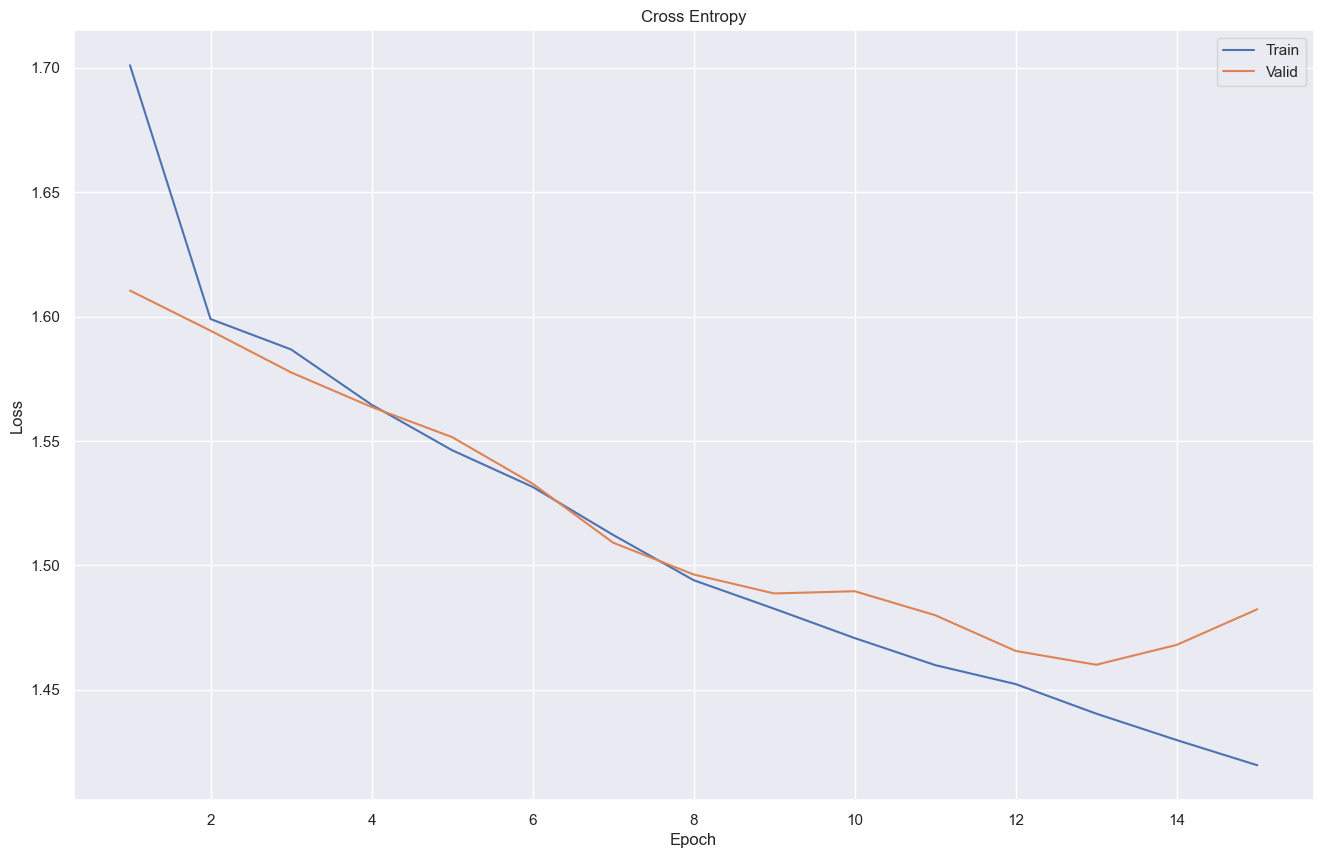

In [19]:
# Display the training and validation loss curves

cnn_plot.show_loss(
	report   = report,
	title    = 'Cross Entropy',
	filename = os.path.join(OUT_PLOT, model.__name__)
)

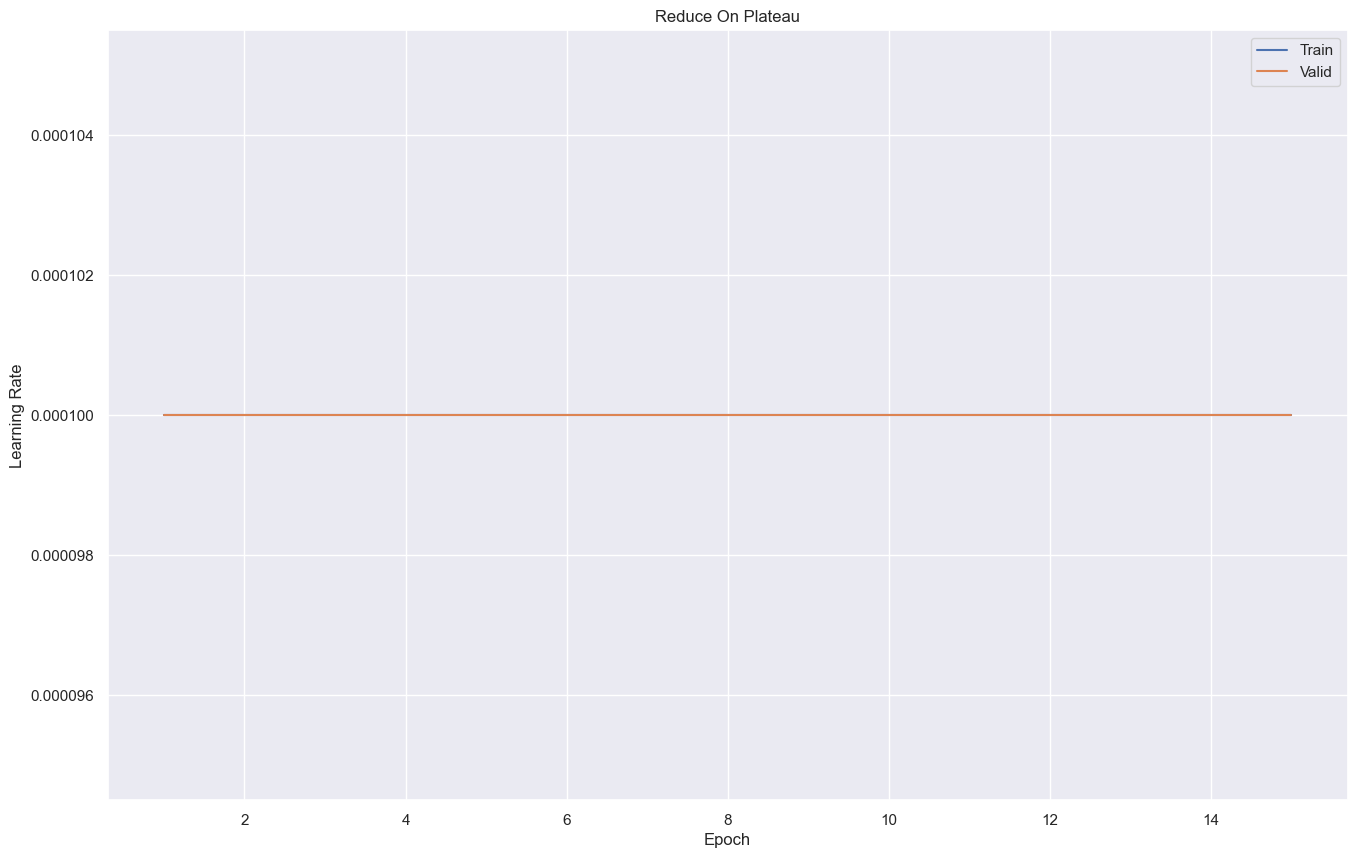

In [20]:
# Display the training and validation learning rate curves

cnn_plot.show_lr(
	report   = report,
	title    = 'Reduce On Plateau',
	filename = os.path.join(OUT_PLOT, model.__name__)
)

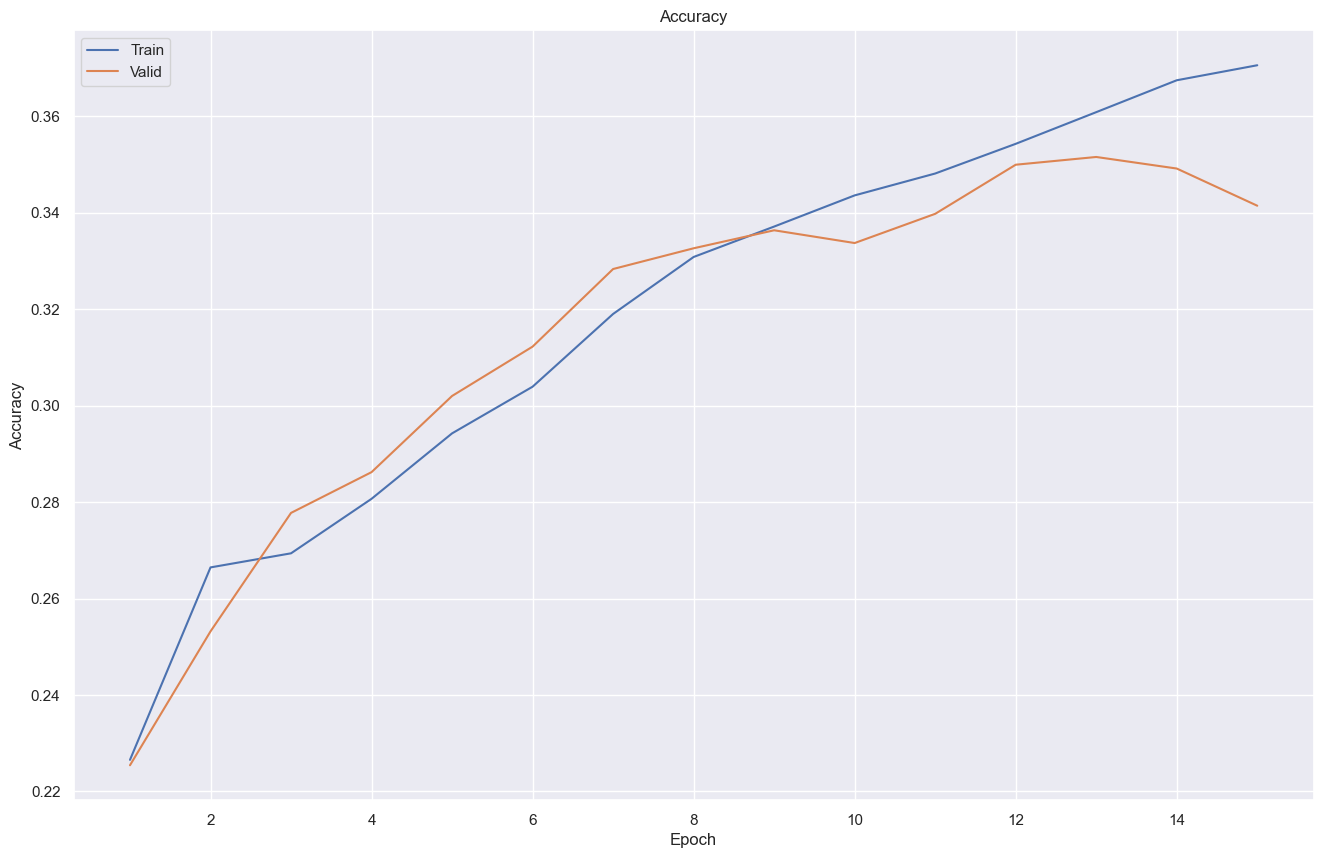

In [21]:
# Display the training and validation learning rate curves

cnn_plot.show_accuracy(
	report   = report,
	title    = 'Accuracy',
	filename = os.path.join(OUT_PLOT, model.__name__)
)

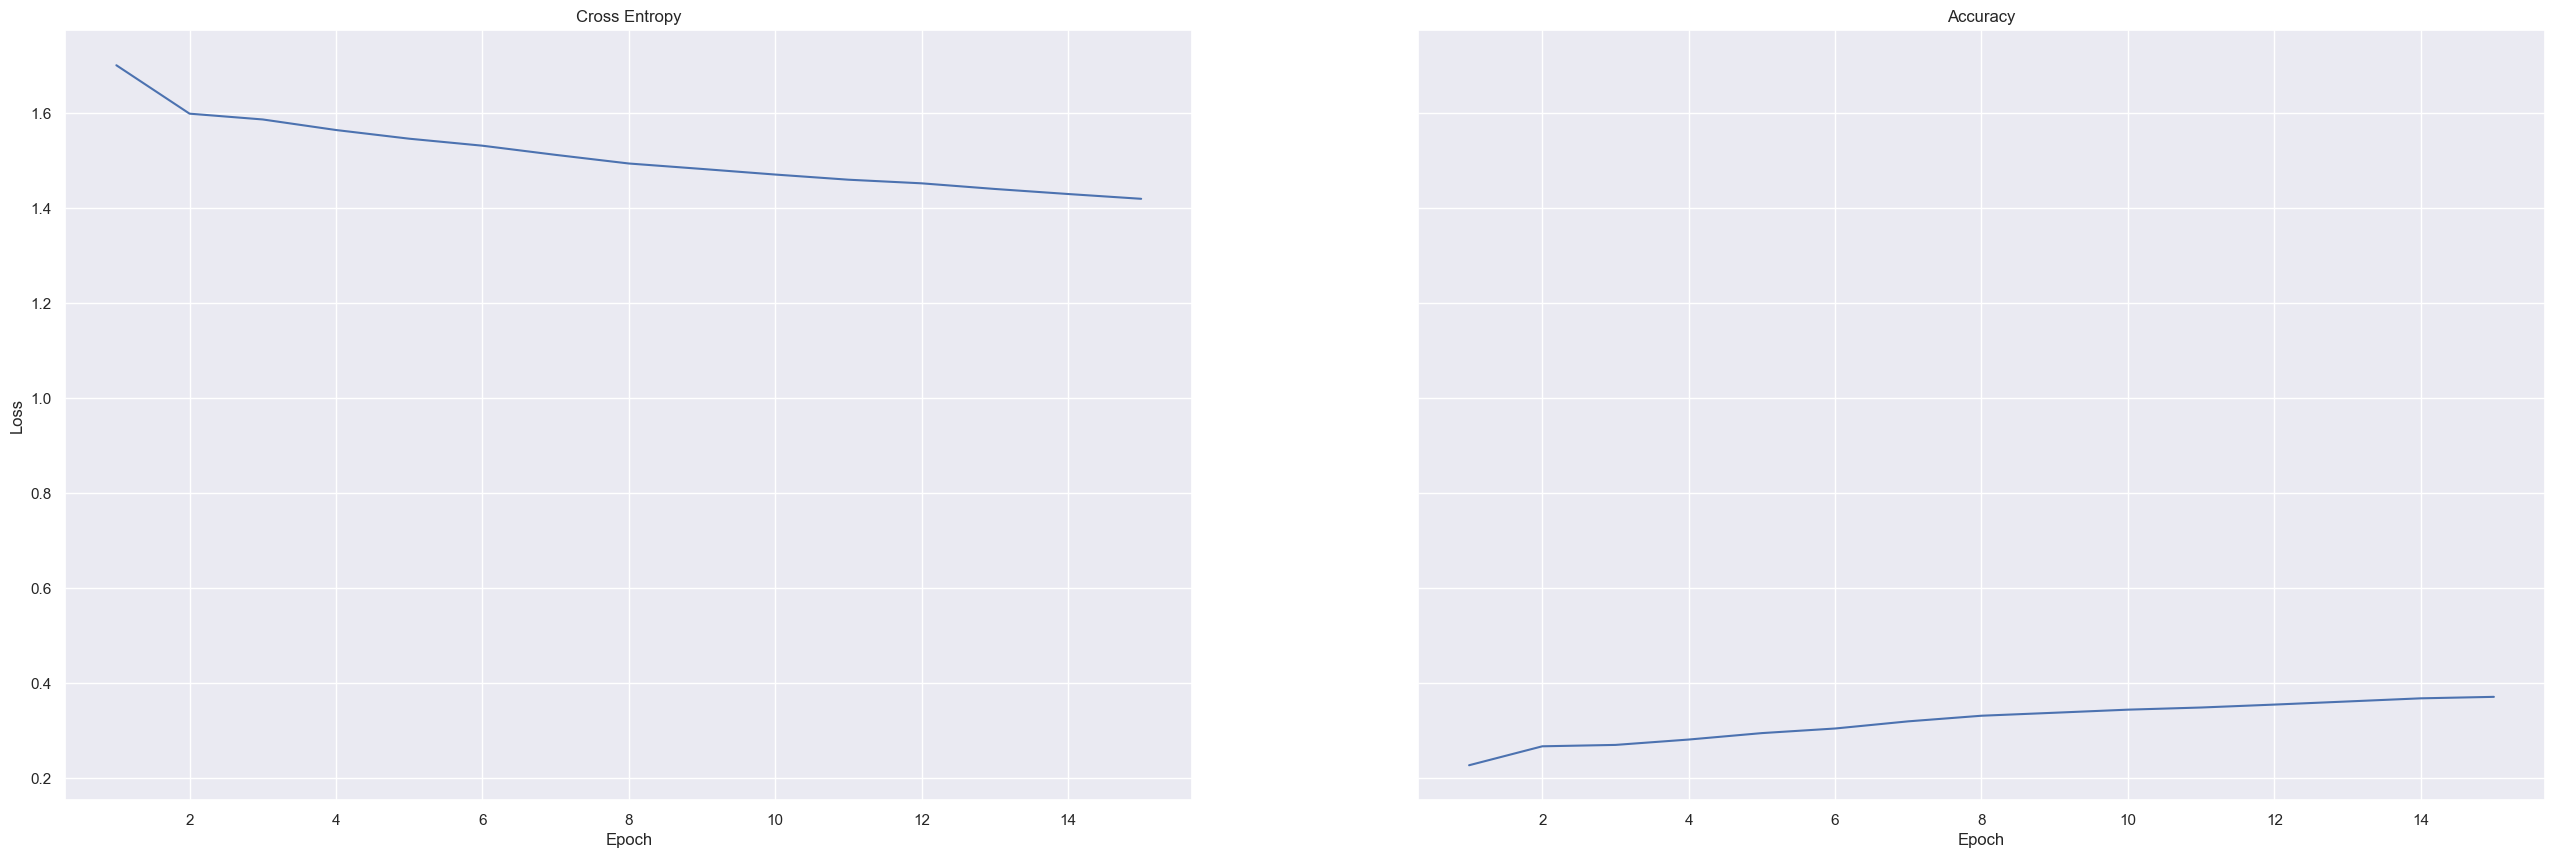

In [22]:
# Display the training metrics per batch

cnn_plot.show_metric_grid(
	report   = report,
	mode     = 'train',
	filename = os.path.join(OUT_PLOT, model.__name__ + '-train')
)

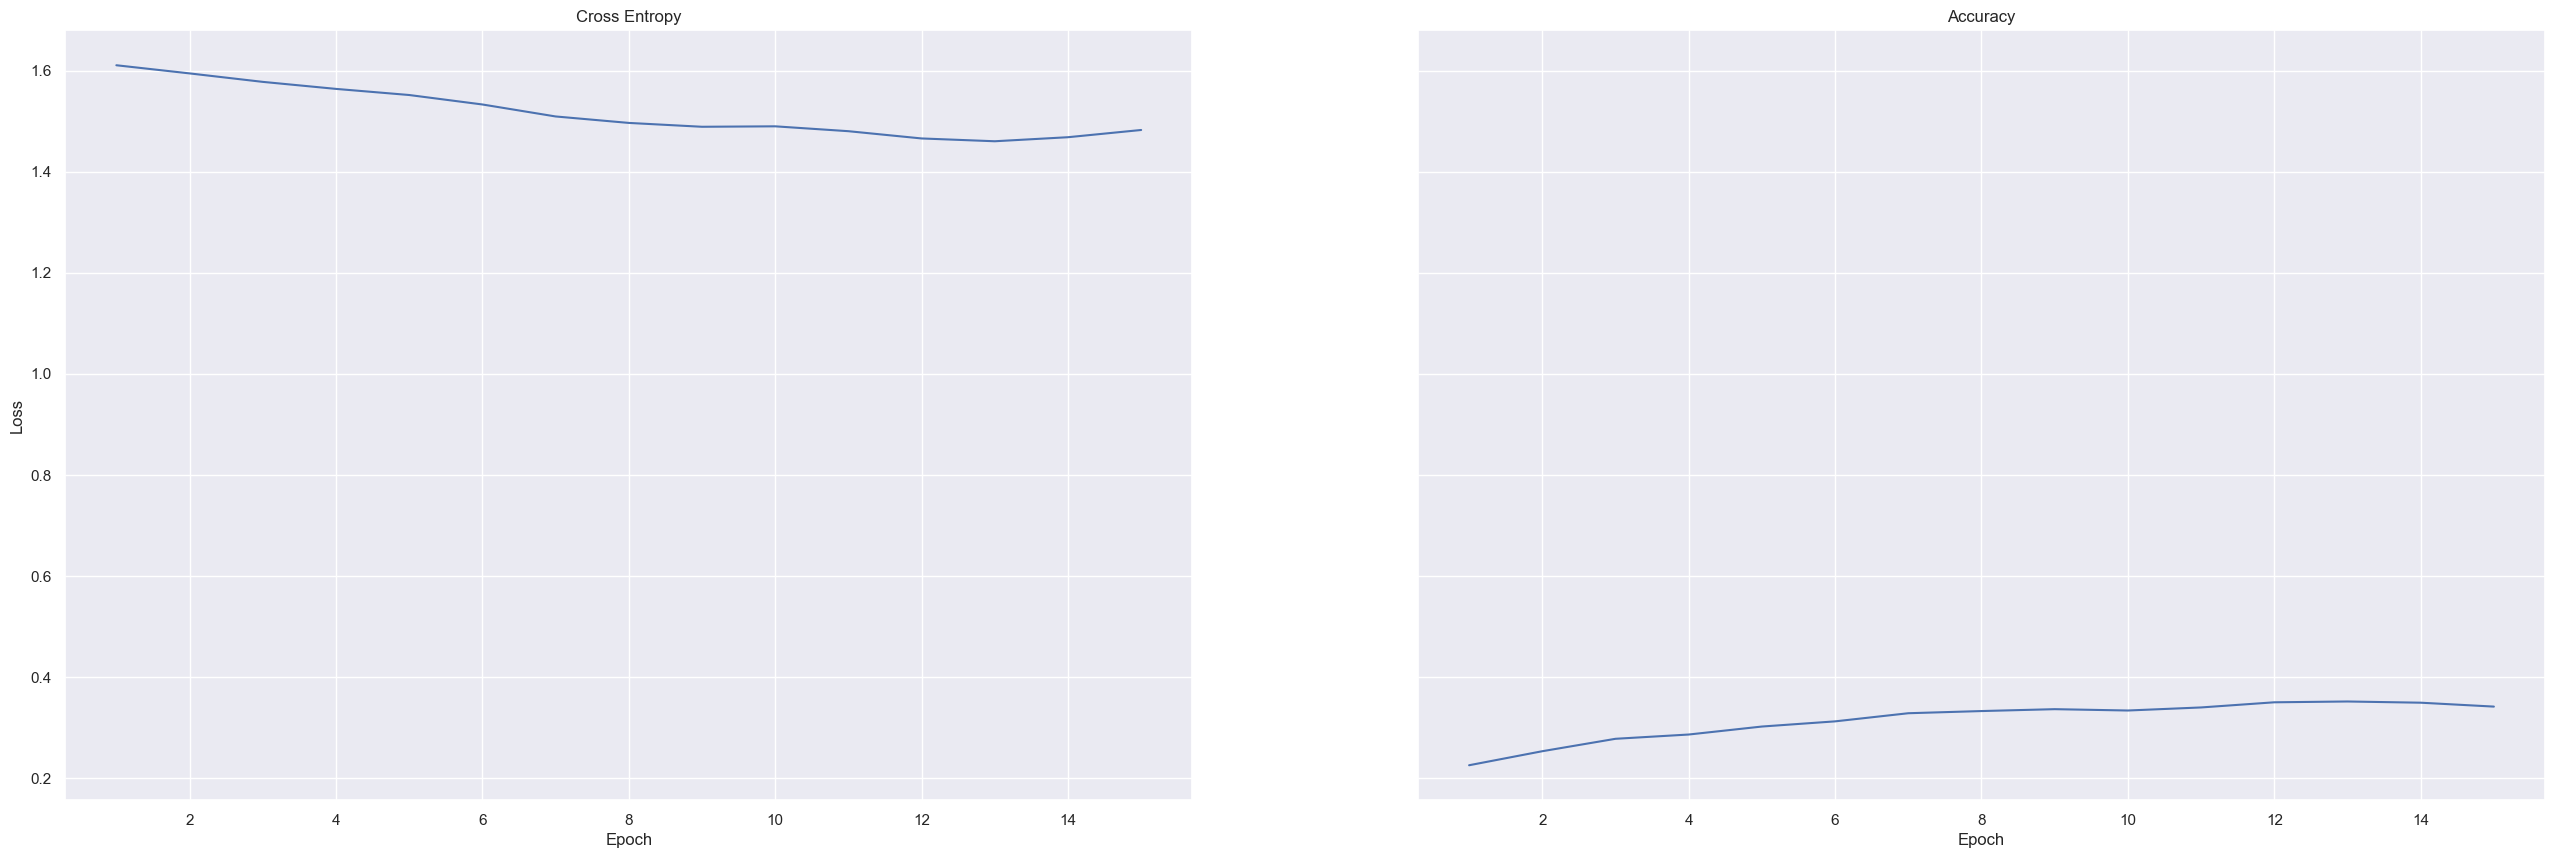

In [23]:
# Display the validation metrics per batch

cnn_plot.show_metric_grid(
	report   = report,
	mode     = 'valid',
	filename = os.path.join(OUT_PLOT, model.__name__ + '-valid')
)

## 2.4 Evaluation

### 2.4.1 Last Model

In [24]:
# Load last model

checkpoint = data_loader.load_torch(
	filename = os.path.join(OUT_MODEL, model.__name__ + '-last.pth')
)

print('Epoch : ' + '{}'.format(checkpoint['epoch']))
print(' Loss : ' + '{:.5f}'.format(checkpoint['loss']))

model.load_state_dict(checkpoint['models'])

Epoch : 15
 Loss : 1.48235


<All keys matched successfully>

In [25]:
# Evaluate the full model

report = cnn_model.eval_classifier(
	model  = model,
	params = params
)

  0%|          | 0/99 [00:00<?, ?it/s]

In [26]:
# Print the evaluation metrics

print('Entropy  : ' + '{: 8.5f}'.format(report['eval']['metric']['entropy'].mean()))
print('Accuracy : ' + '{: 8.5f}'.format(report['eval']['metric']['accuracy'].mean()))

Entropy  :  1.47511
Accuracy :  0.34069


In [27]:
# Display the first few evaluation item predictions and expectations

cnn_util.display_classification_predictions(report = report, n = 2)

Gene     : AT2G40020.2
True     : [1 1 1 0 1 1 0 0]
Pred     : [4 0 2 4 1 4 0 0]
Entropy  : [1.78581   1.59650   1.52441   1.69903   1.50463   1.58869   1.19074   0.91826]
Accuracy : [0.00000   0.00000   0.00000   0.00000   1.00000   0.00000   1.00000   1.00000]

Gene     : AT5G64520.9
True     : [2 1 1 1 1 0 0 0]
Pred     : [4 0 2 3 1 1 0 0]
Entropy  : [1.56281   1.55215   1.43244   1.76802   1.40917   1.69743   1.01728   0.76046]
Accuracy : [0.00000   0.00000   0.00000   0.00000   1.00000   0.00000   1.00000   1.00000]



In [28]:
# Display the evaluation accuracy

dataframe = cnn_util.display_classification_accuracy(
	report = report['eval'],
	order  = tpm_order[config['output']['group0']]
).sort_values('Accuracy', ascending = False)

print('Average Accuracy : {:8.5f} %'.format(dataframe['Accuracy'].mean()))
print('Average Missed 1 : {:8.5f} %'.format(dataframe['Missed_1'].mean()))
print('Average Missed 2 : {:8.5f} %'.format(dataframe['Missed_2'].mean()))
print('Average Missed 3 : {:8.5f} %'.format(dataframe['Missed_3'].mean()))
print('Average Missed 4 : {:8.5f} %'.format(dataframe['Missed_4'].mean()))
print()

dataframe

Average Accuracy : 34.06921 %
Average Missed 1 : 29.95581 %
Average Missed 2 : 18.87626 %
Average Missed 3 : 11.64181 %
Average Missed 4 :  5.45691 %



,Group,Total,Accuracy,Missed_1,Missed_2,Missed_3,Missed_4
7,senescence_reproductive,6336,41.38,32.29,17.63,7.70,0.99
0,flower,6336,36.25,28.82,18.37,9.61,6.94
3,root,6336,34.64,25.69,18.42,12.97,8.27
5,seedling,6336,32.89,28.54,19.30,13.43,5.84
4,seed,6336,32.62,28.85,19.71,12.96,5.86
1,leaf,6336,32.43,26.80,18.21,14.46,8.10
6,senescence_green,6336,32.28,31.04,19.44,12.61,4.62
2,other,6336,30.05,37.61,19.92,9.39,3.03


### 2.4.2 Best Model

In [29]:
# Load best model

checkpoint = data_loader.load_torch(
	filename = os.path.join(OUT_MODEL, model.__name__ + '-best.pth')
)

print('Epoch : ' + '{}'.format(checkpoint['epoch']))
print(' Loss : ' + '{:.5f}'.format(checkpoint['loss']))

model.load_state_dict(checkpoint['models'])

Epoch : 13
 Loss : 1.46005


<All keys matched successfully>

In [30]:
# Evaluate the full model

report = cnn_model.eval_classifier(
	model  = model,
	params = params
)

  0%|          | 0/99 [00:00<?, ?it/s]

In [31]:
# Print the evaluation metrics

print('Entropy  : ' + '{: 8.5f}'.format(report['eval']['metric']['entropy'].mean()))
print('Accuracy : ' + '{: 8.5f}'.format(report['eval']['metric']['accuracy'].mean()))

Entropy  :  1.45611
Accuracy :  0.35277


In [32]:
# Display the first few evaluation item predictions and expectations

cnn_util.display_classification_predictions(report = report, n = 2)

Gene     : AT4G00420.5
True     : [0 1 0 1 1 1 1 0]
Pred     : [4 0 3 4 3 3 0 0]
Entropy  : [2.06621   1.67006   1.85285   1.91820   1.51602   1.67962   1.66211   0.83187]
Accuracy : [0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   1.00000]

Gene     : AT1G18700.4
True     : [1 1 0 0 1 1 0 0]
Pred     : [0 0 0 0 0 0 0 0]
Entropy  : [1.72660   1.87482   1.11780   1.08361   1.44346   1.57245   0.59977   0.49843]
Accuracy : [0.00000   0.00000   1.00000   1.00000   0.00000   0.00000   1.00000   1.00000]



In [33]:
# Display the evaluation accuracy

dataframe = cnn_util.display_classification_accuracy(
	report = report['eval'],
	order  = tpm_order[config['output']['group0']]
).sort_values('Accuracy', ascending = False)

print('Average Accuracy : {:8.5f} %'.format(dataframe['Accuracy'].mean()))
print('Average Missed 1 : {:8.5f} %'.format(dataframe['Missed_1'].mean()))
print('Average Missed 2 : {:8.5f} %'.format(dataframe['Missed_2'].mean()))
print('Average Missed 3 : {:8.5f} %'.format(dataframe['Missed_3'].mean()))
print('Average Missed 4 : {:8.5f} %'.format(dataframe['Missed_4'].mean()))
print()

dataframe

Average Accuracy : 35.27659 %
Average Missed 1 : 31.09612 %
Average Missed 2 : 18.29230 %
Average Missed 3 : 10.72049 %
Average Missed 4 :  4.61450 %



,Group,Total,Accuracy,Missed_1,Missed_2,Missed_3,Missed_4
7,senescence_reproductive,6336,42.08,32.94,17.42,6.71,0.85
0,flower,6336,38.56,28.39,17.49,9.90,5.67
3,root,6336,35.70,26.59,18.04,12.11,7.56
4,seed,6336,34.28,29.75,19.62,11.60,4.75
1,leaf,6336,33.85,27.46,18.09,13.45,7.15
5,seedling,6336,33.78,30.11,18.48,12.64,4.99
6,senescence_green,6336,32.50,33.55,18.61,11.52,3.82
2,other,6336,31.47,39.96,18.59,7.84,2.13
